## Intregration of Human Head and Neck Squamous Cell Carcinoma samples from *Zheng et al.* in Nature Communications published in 2020. __[(GSE145370)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145370)__

#### Import the necessary libraries to integrate the data before normalization

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import scvi

/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Initially one of the samples is loaded to explore teh data. The overall goal here is to get a rough idea for cutoffs for filtering to be used in the integration function

In [2]:
adata = sc.read_10x_mtx('Zheng_NatCom_2020/Data/ESCC_Tumor/S133A_filtered_feature_bc_matrix/',
                           var_names = 'gene_symbols',
                           cache=True)

/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


#### Criteria is at least 200 genes per cell and each gene must be present in at least 3 cells

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata,min_cells = 3)

#### Here we index a mitochondrial column to use in quality control of this dataset

In [19]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)


#### Now to visualize our quality control metrics of number of genes, our total cells and how many of the genes are mitochondrial related genes

/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

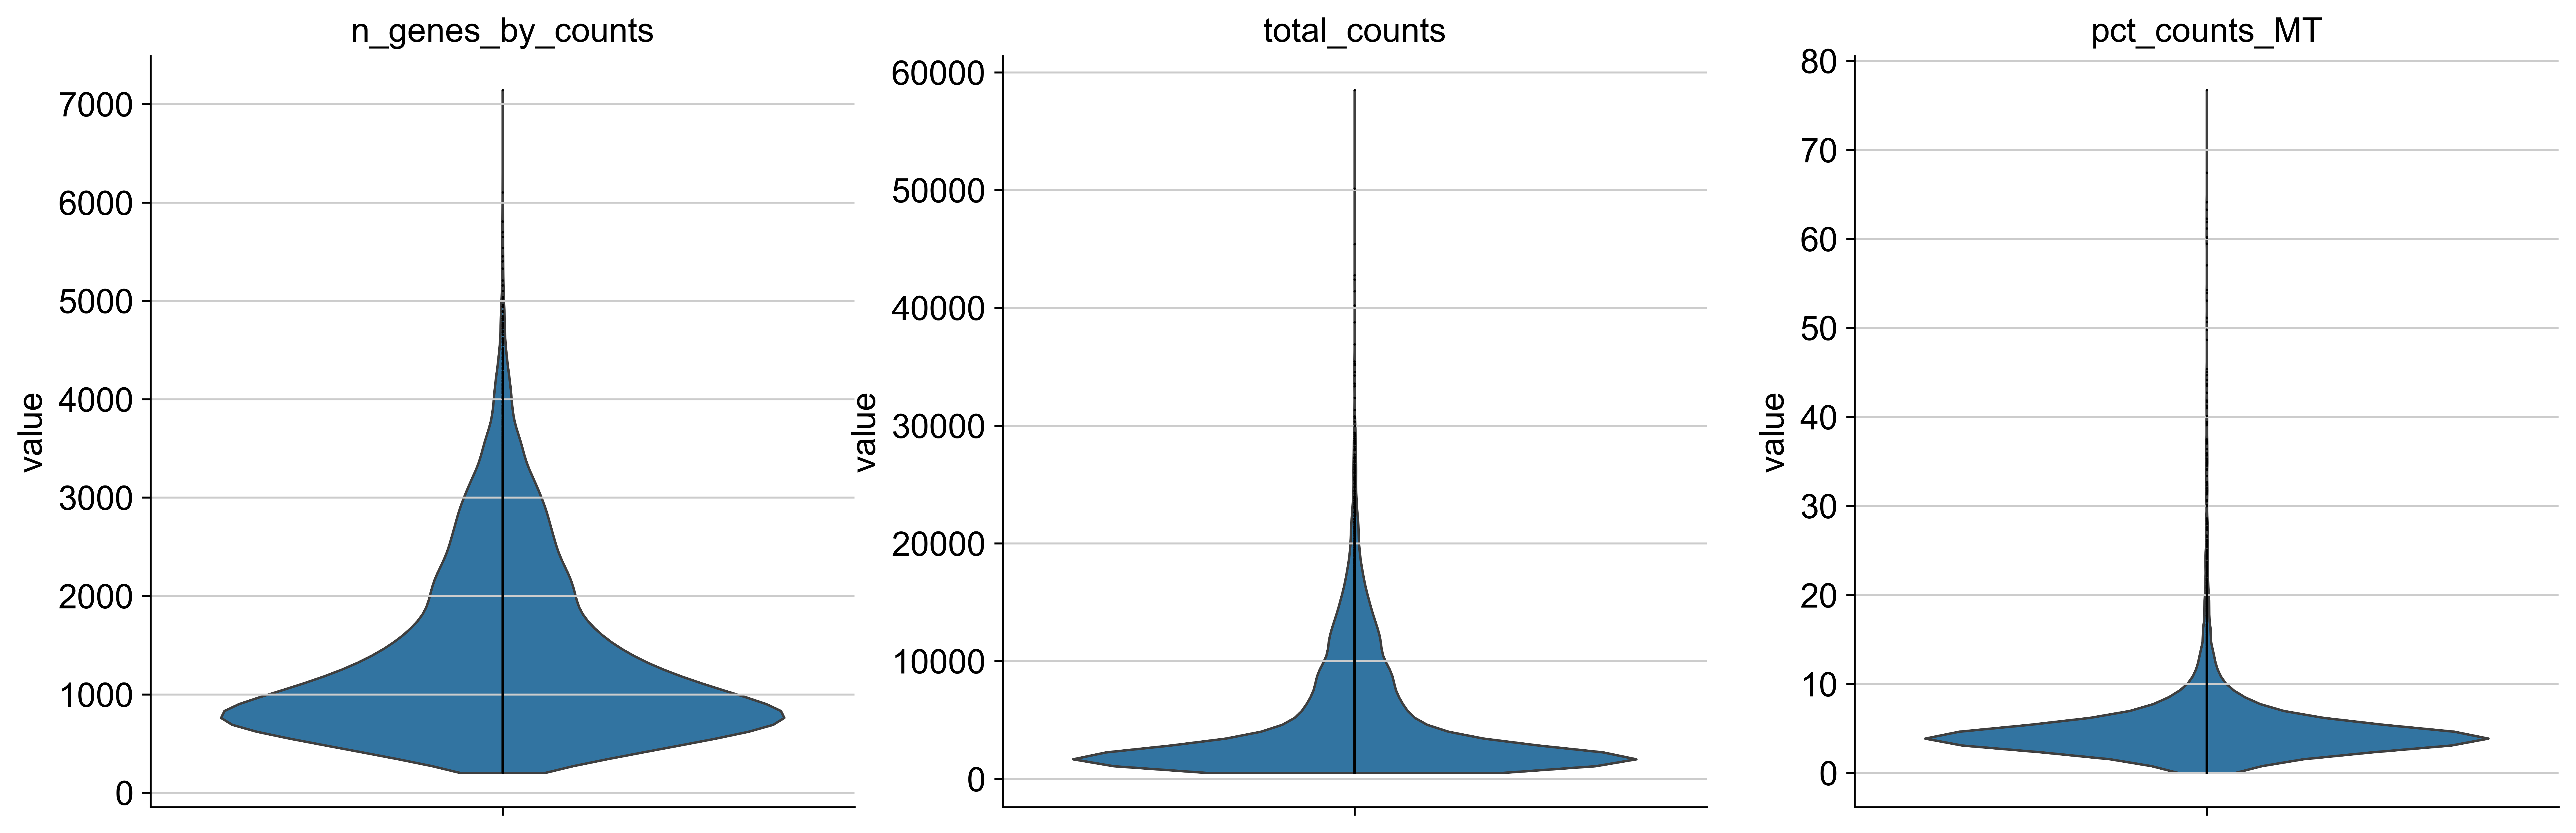

In [22]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'],
             jitter=False, 
             multi_panel=True, 
             linewidth = 1)

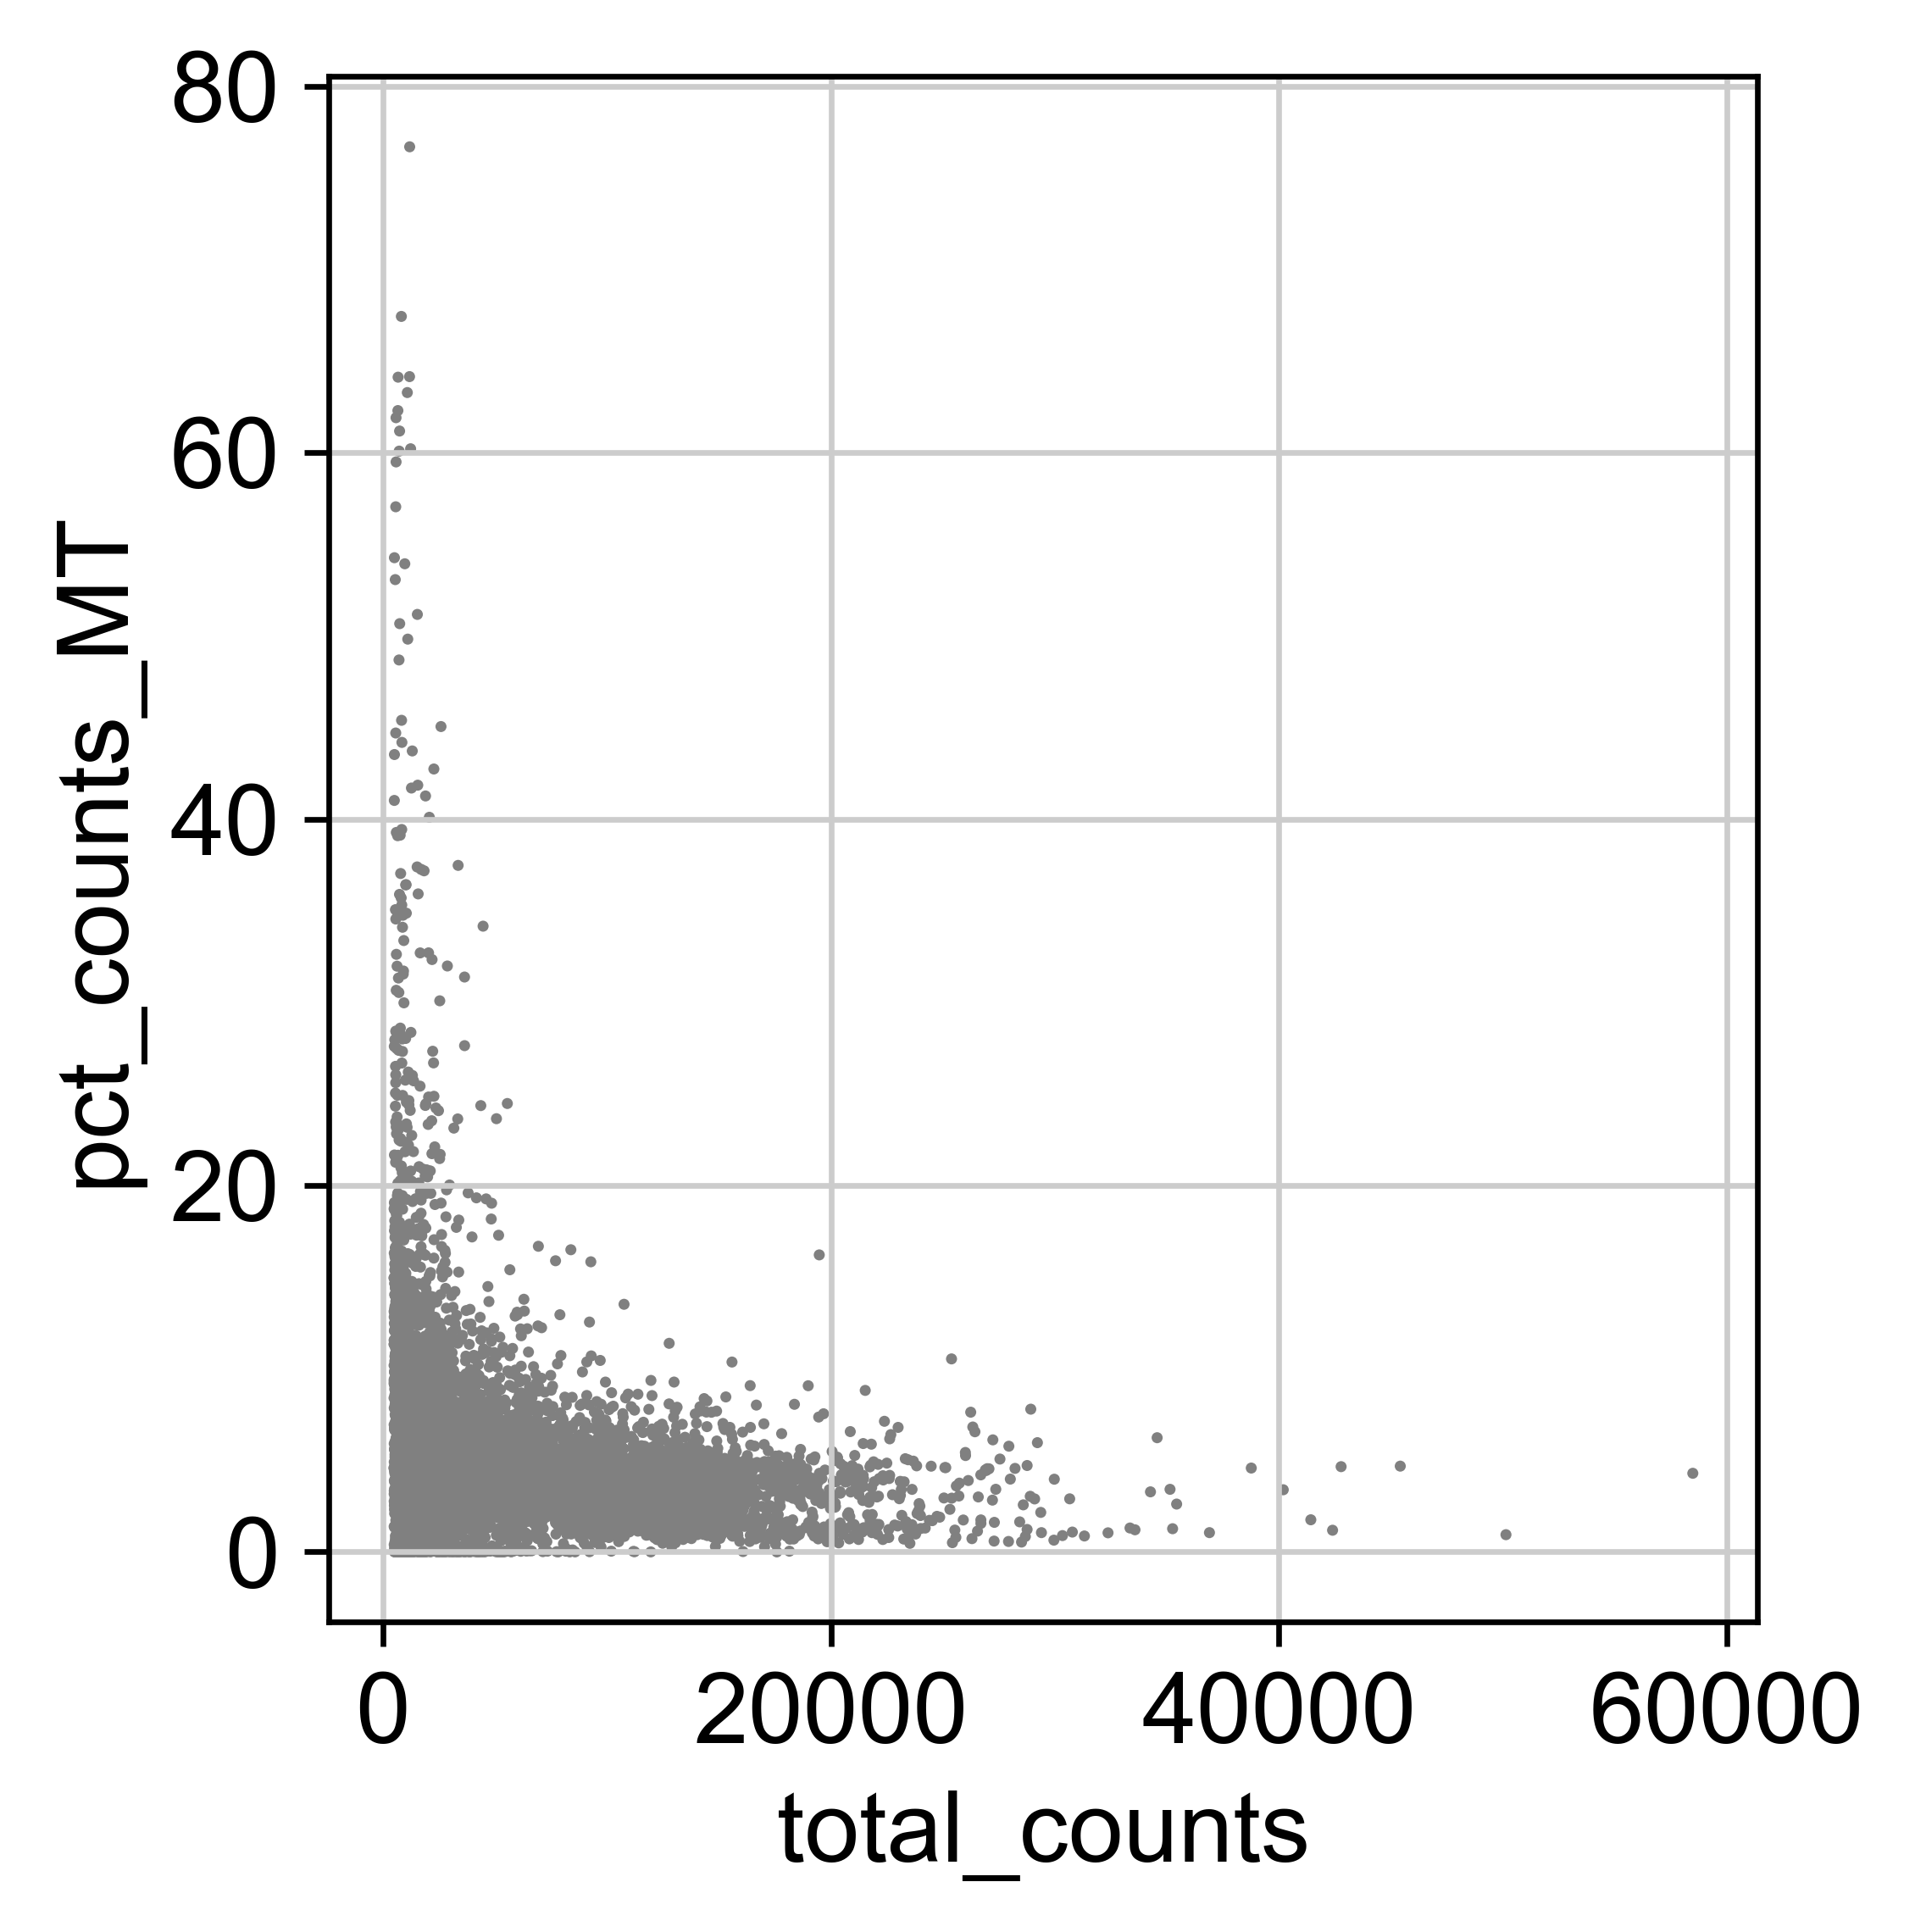

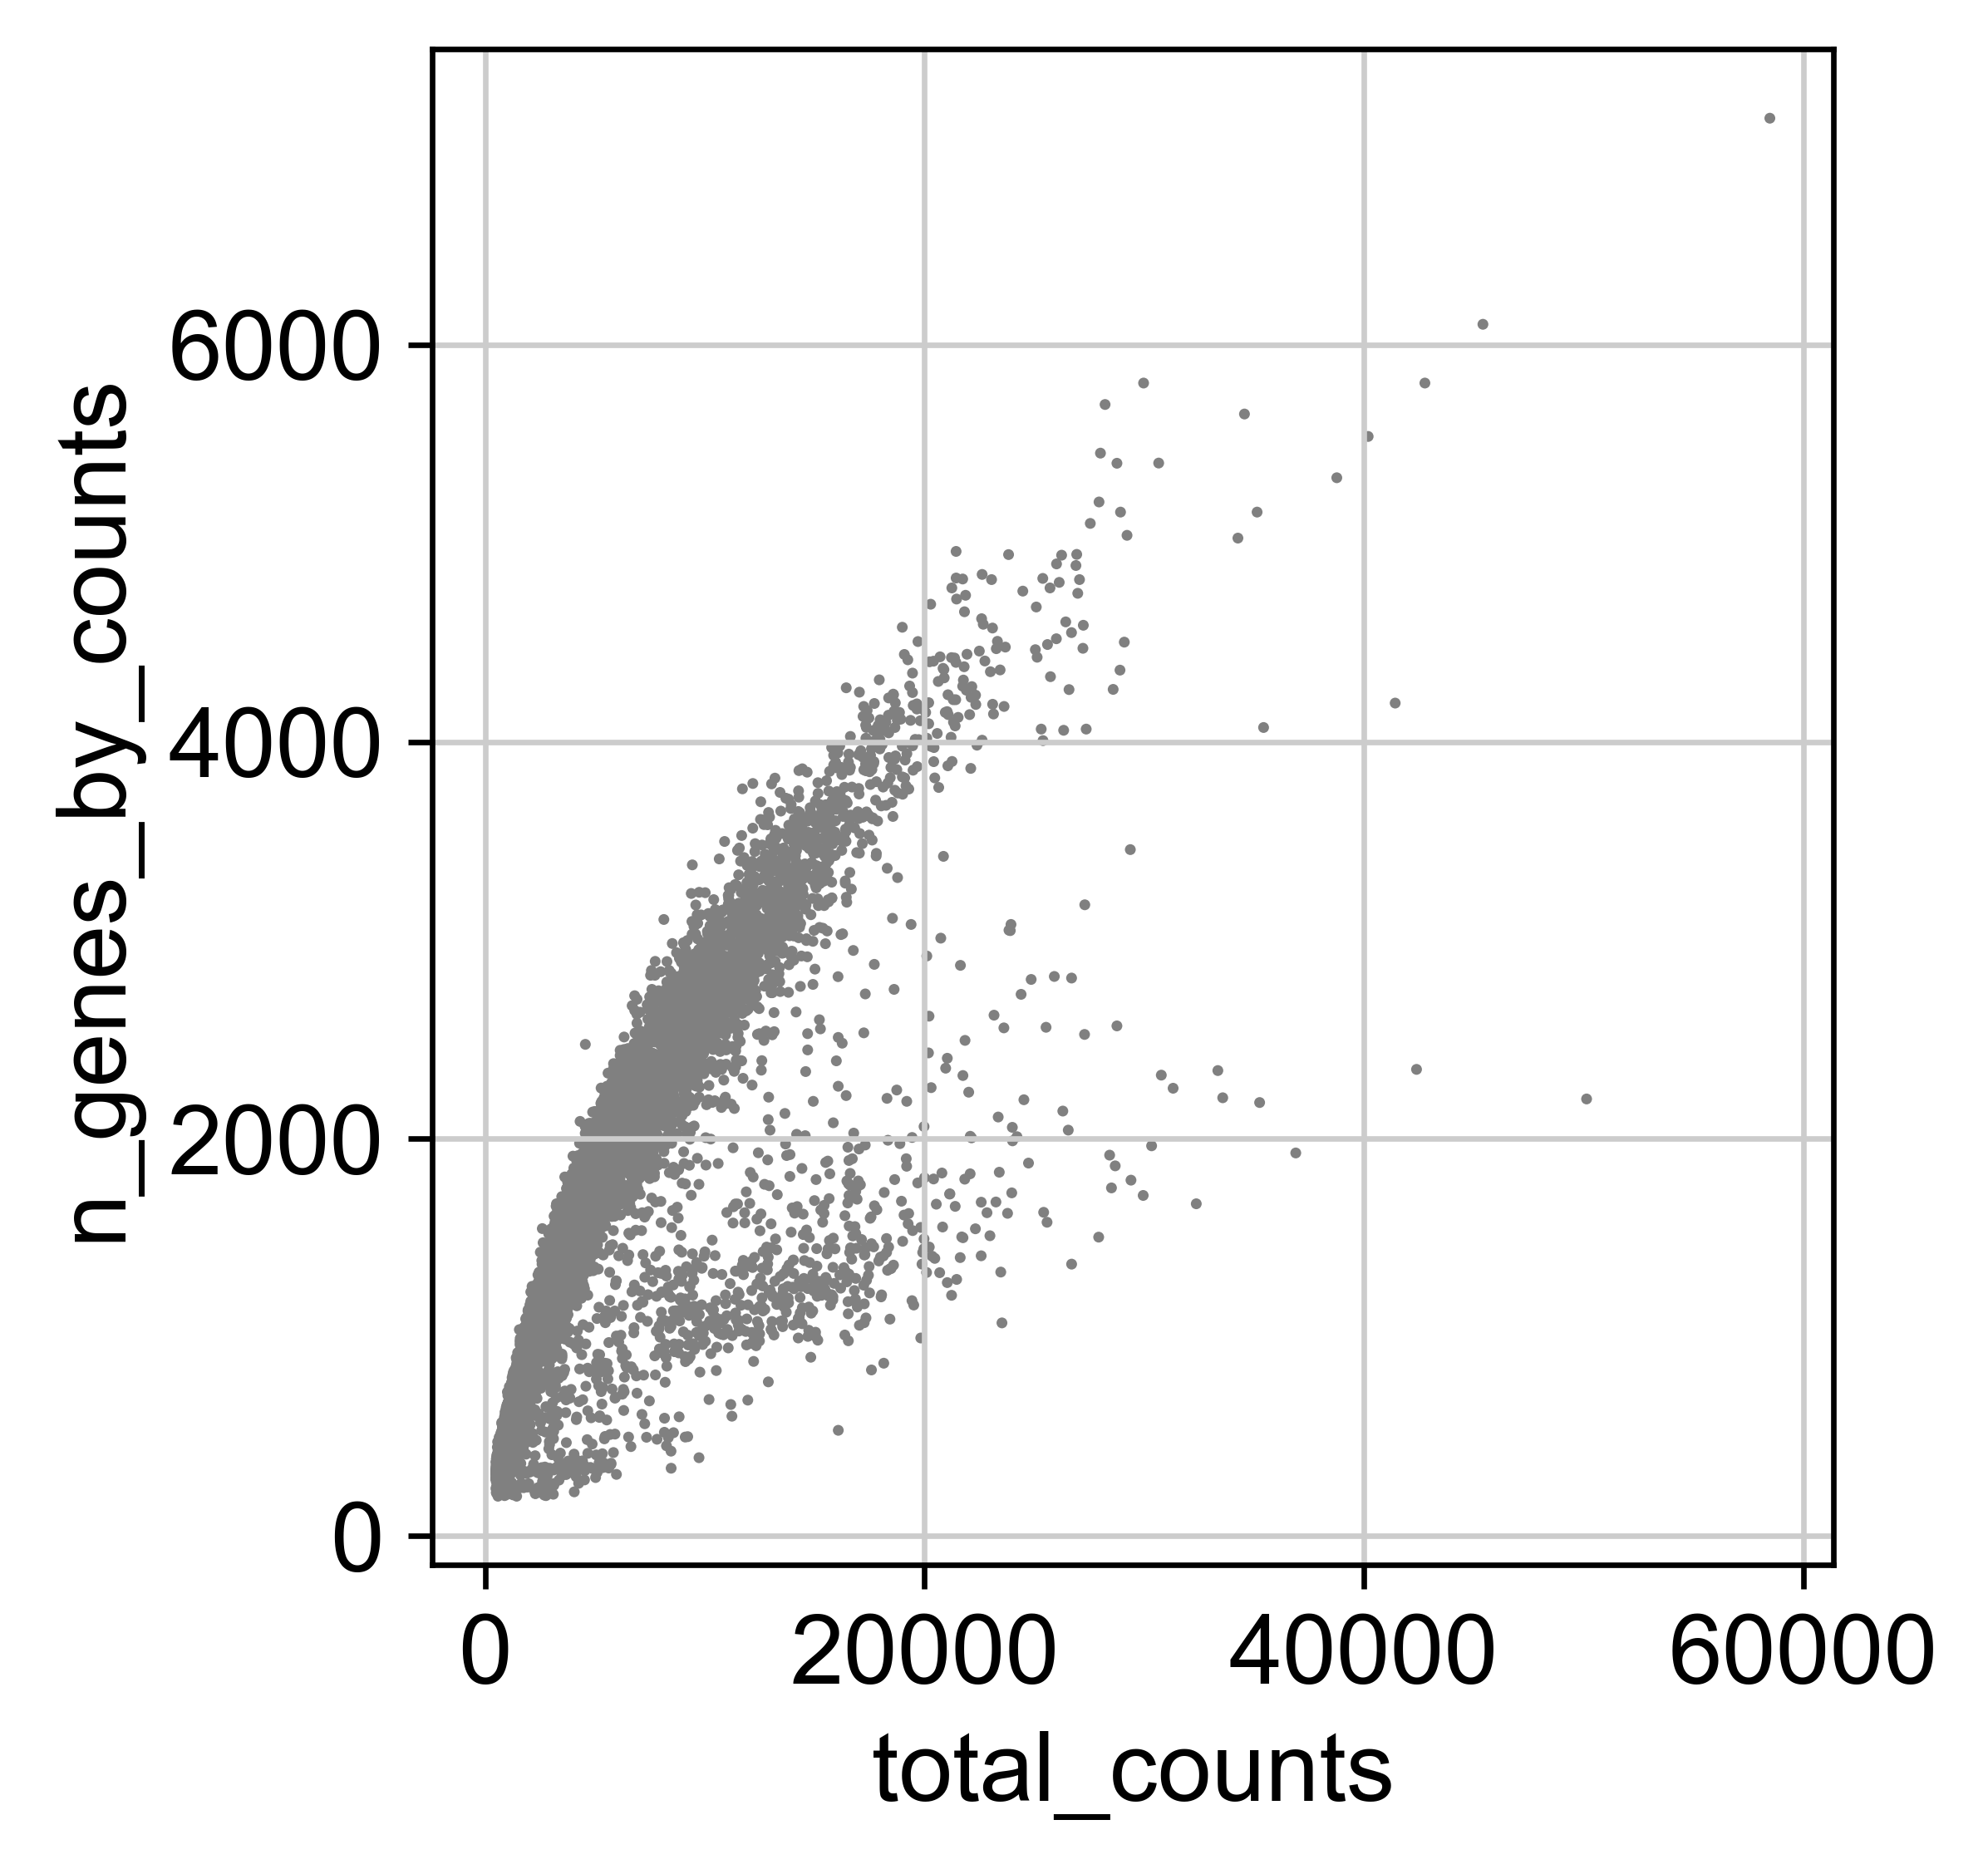

In [16]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

#### Now that we have defined general metrics to use for filtering, we can now create a function that will integrate all of our data together

In [16]:
def pp(mtx_path):
    
    adata = sc.read_10x_mtx(mtx_path)
    adata.obs['Sample'] = mtx_path.split('_')[3]
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .95)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 15]
    return adata


#### To execute the integration we first create two seperate dataframes called Tumor and Normal then use the scanpy concatenate command to combine them together into one file.

In [21]:
Tumor = []
for subdir in os.listdir('Zheng_NatCom_2020/Data/ESCC_Tumor_Data/'):
    Tumor.append(pp('Zheng_NatCom_2020/Data/ESCC_Tumor_Data/' + subdir))

Normal = []
for subdir in os.listdir('Zheng_NatCom_2020/Data/ESCC_Normal_Data/'):
    Normal.append(pp('Zheng_NatCom_2020/Data/ESCC_Normal_Data/' + subdir))

    adata_tumor = sc.concat(Tumor)
    adata_normal = sc.concat(Normal)

    combined = [adata_tumor,adata_normal]

    adata_combined = sc.concat(combined)

/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/jordon/anaconda3/envs/analysis/lib/python3.10/site-packag

In [22]:
adata_normal.var_names_make_unique
adata_tumor.var_names_make_unique
adata_combined.var_names_make_unique

adata_tumor.write_h5ad('tumor_only.h5ad')
adata_normal.write_h5ad('normal_only.h5ad')
adata_combined.write_h5ad('integrated.h5ad')